In [49]:
from causalgraphicalmodels import CausalGraphicalModel
import numpy as np
import pandas as pd
import random
import generate_network
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

import DistCor, RegDep
from sklearn import linear_model
where_data = "/home/andy/Distance_correlation_data/network_backgrounds/"

def distance_variance(var, data):
    return DistCor.squared_pop_dCov(data[var].to_numpy(), data[var].to_numpy())

def distance_covariance_from_UCMD(Uv1, Uv2, n = 150):
    return 2 * Uv1.T.dot(Uv2)/(n * (n - 3))

def distance_variance_from_UCMD(UCMD_vector, n = 150):
    return 2 * UCMD_vector.T.dot(UCMD_vector)/(n * (n - 3))

def give_joint_plot(var_1, var_2, conditioning, data, center=False, x_lim=None, y_lim=None, cmap="viridis", kind="hex"):
    n = data.shape[0]
    t, UCMD_1, UCMD_2 = DistCor.pdcov_test_statistic(data[var_1].to_numpy(), data[var_2].to_numpy(), data[conditioning].to_numpy())
    triu_indices = np.triu_indices_from(UCMD_1, k=1)
    U_vector_1 = UCMD_1[triu_indices].reshape(-1, 1)
    U_vector_2 = UCMD_2[triu_indices].reshape(-1, 1)
    
    dvar1= np.sqrt(distance_variance_from_UCMD(U_vector_1, n)[0][0])
    dvar2= np.sqrt(distance_variance_from_UCMD(U_vector_2, n)[0][0])
    dcov = distance_covariance_from_UCMD(U_vector_1, U_vector_2, n)[0][0]

    plot = sns.jointplot(x=U_vector_1, y=U_vector_2, kind=kind, cmap=cmap, joint_kws={'mincnt':1}, marginal_kws={'color': 'indigo', 'hist_kws':{"alpha":1}})
    
    
    if center:
        xlim = plot.ax_marg_x.get_xlim()
        extreme = max([abs(xlim[0]), abs(xlim[1])])
        plot.ax_marg_x.set_xlim(-extreme, extreme)
        
        ylim = plot.ax_marg_y.get_ylim()
        extreme = max([abs(ylim[0]), abs(ylim[1])])
        plot.ax_marg_y.set_ylim(-extreme, extreme)
    else:
        if x_lim:
            plot.ax_marg_x.set_xlim(*x_lim)
        if y_lim:
            plot.ax_marg_y.set_ylim(*y_lim)
    if conditioning:
        plot.set_axis_labels(", ".join(var_1) + r"$_{\bot_{" + ", ".join(conditioning) + r"}}$" + f" (dvar={dvar1:.2f})", ", ".join(var_2) + r"$_{\bot_{" + ", ".join(conditioning) + r"}}$" + f" (dvar={dvar2:.2f})", fontsize=16)
    else:
        plot.set_axis_labels(", ".join(var_1) + f" (dvar={dvar1:.2f})", ", ".join(var_2) + f" (dvar={dvar2:.2f})", fontsize=16)
    #j.annotate(stats.pearsonr)
    ax = plt.sca(plot.ax_joint)
    dcorsq = dcov / np.sqrt(dvar1**2 * dvar2**2)
    plt.text(x = 0.05, y=0.95, s=r"$dcov^2 = $" + f"{dcov:.2f}" + ", " + r"$dcor^2=$" + f"{dcorsq:.2f}", fontsize=20, transform = plot.ax_joint.transAxes)
    #plt.subplots_adjust(top=0.95)
    if conditioning:
        dvar_conditioning = np.sqrt(distance_variance(conditioning, data))
        plt.text(0.9, 0.9, r"$dvar_{Z}$" + f"\n{dvar_conditioning:.2f}", fontsize=14, transform=plt.gcf().transFigure, horizontalalignment='center', verticalalignment='center')
    return plot, dcov, dvar1, dvar2

def plot_residuals(var1, var2, conditioning, df):
    model1 = linear_model.LinearRegression().fit(df[conditioning], df[var1])
    resid1 = df[var1] - model1.predict(df[conditioning])
  

    model2 = linear_model.LinearRegression().fit(df[conditioning], df[var2])
    resid2 = df[var2] - model2.predict(df[conditioning])


    #fig2, ax2 = plt.subplots(figsize=(8, 8))
    df_resids = pd.DataFrame({f"{var1}_resid": resid1, f"{var2}_resid": resid2})
    plot = sns.jointplot(x=f"{var1}_resid", y=f"{var2}_resid", data= df_resids, kind="reg")
    if conditioning:
        plot.set_axis_labels(", ".join(var1) + r"$_{\bot_{" + ", ".join(conditioning) + r"}}$", ", ".join(var2) + r"$_{\bot_{" + ", ".join(conditioning) + r"}}$", fontsize=16)
    else:
        plot.set_axis_labels(", ".join(var1), ", ".join(var2), fontsize=16)

    return plot

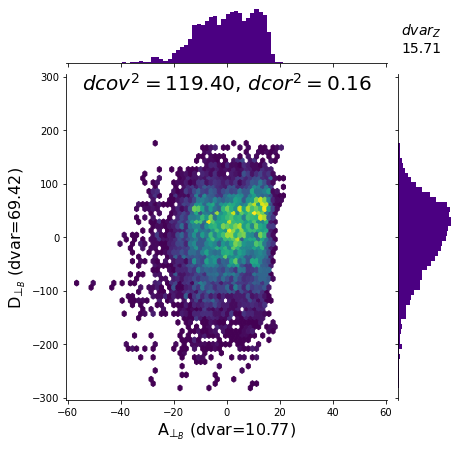

In [50]:
net = 2
data = pd.read_csv(where_data + f"net{net}/data_for_net{net}-150-linear.csv", index_col=0)
var_1 = ["A"]
var_2 = ["D"]
conditioning = ["B"]
plot, dcov, dvar1, dvar2 = give_joint_plot(var_1, var_2, conditioning, data, center=True)#, [-15, 15], [-15, 15])

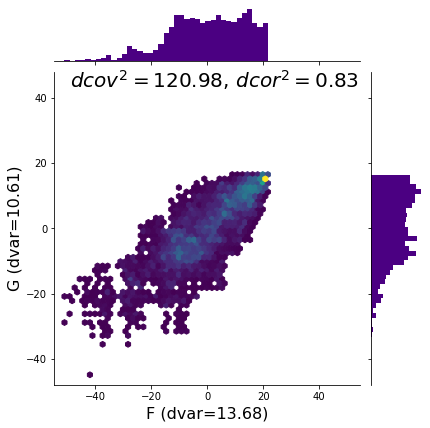

In [107]:
net = 4
samples=150
parametrization="linear"
data = pd.read_csv(where_data + f"net{net}/data_for_net{net}-{samples}-{parametrization}.csv", index_col=0)
var1="F"
var2="G"
conditioning=[]

plot, dcov, dvar1, dvar2 = give_joint_plot(var1, var2, conditioning, data, center=True)#, [-15, 15], [-15, 15])
plt.subplots_adjust(bottom=0.10, left=0.12)
plt.savefig(f'DistanceResiduals_for_Net{net}-{samples}-{parametrization}-{var1}-{var2}-{"_".join(conditioning)}.png', dpi=300)

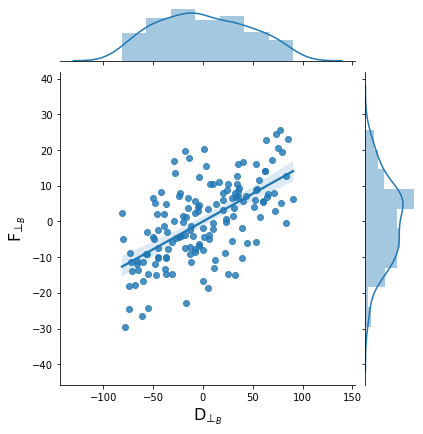

In [71]:
net = 4
samples=150
parametrization="linear"
data = pd.read_csv(where_data + f"net{net}/data_for_net{net}-{samples}-{parametrization}.csv", index_col=0)
var1="D"
var2="F"
conditioning=["B"]
plot_residuals(var1, var2, conditioning, data)
plt.subplots_adjust(left=0.15)
plt.savefig(f'Regresid_for_Net{net}-{samples}-{parametrization}-{var1}-{var2}-{"_".join(conditioning)}.png', dpi=300)